In [1]:
import torch
import gym
import numpy as np
from collections import deque
import time
from ReplayBuffer import ReplayBuffer
from Model import TD3
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#env_name = 'BipedalWalker-v2'
#env_name = 'BipedalWalkerHardcore-v2'
env_name = 'LunarLanderContinuous-v2'
random_seed = 0
save_every = 500            # safe trained models after interval
print_every = 10
directory = "./preTrained/" # save trained models
filename = "TD3_{}_{}".format(env_name, random_seed)
continue_training = False

# Hyperparameters
max_episodes = 20000        # max num of episodes
max_timesteps = 1500        # max timesteps in one episode

gamma = 0.99                # discount for future rewards
batch_size = 100            # num of transitions sampled from replay buffer
exploration_noise = 0.1 
polyak = 0.995              # target policy update parameter (1-tau)
policy_noise = 0.2          # target policy smoothing noise
noise_clip = 0.5
policy_delay = 2            # delayed policy updates parameter

In [3]:
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

env.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

c:\users\tobias\appdata\local\conda\conda\envs\openai\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Train

Episode 10, Average Score: -443.49, Max: -96.99, Min: -1020.56, Time: 2.55
Episode 20, Average Score: -311.57, Max: -85.98, Min: -725.65, Time: 2.87
Episode 30, Average Score: -299.37, Max: -86.30, Min: -991.05, Time: 2.73
Episode 40, Average Score: -173.87, Max: -40.13, Min: -286.20, Time: 2.91
Episode 50, Average Score: -233.70, Max: -79.12, Min: -450.60, Time: 10.36
Episode 60, Average Score: -130.93, Max: 159.26, Min: -347.51, Time: 6.33
Episode 70, Average Score: -156.54, Max: 37.85, Min: -295.10, Time: 5.49
Episode 80, Average Score: -281.99, Max: -25.23, Min: -489.93, Time: 28.04
Episode 90, Average Score: -194.76, Max: -98.49, Min: -376.03, Time: 27.24
Episode 100, Average Score: -210.95, Max: -76.56, Min: -482.99, Time: 4.70
Episode 110, Average Score: -129.20, Max: 14.43, Min: -419.58, Time: 6.61
Episode 120, Average Score: -148.92, Max: -3.72, Min: -402.21, Time: 3.26
Episode 130, Average Score: -29.11, Max: 174.58, Min: -98.24, Time: 24.01
Episode 140, Average Score: -78.52

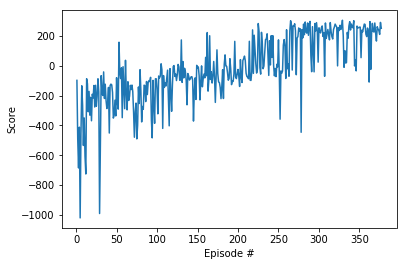

In [4]:
def train():
    policy = TD3(state_dim, action_dim, max_action)
    
    if continue_training:
        policy.load(directory, filename)
    
    replay_buffer = ReplayBuffer()

    scores = []
    avg_reward = 0    
    episode_rewards = []
    
    ep_rewards_deque = deque(maxlen=100)

    for i_episode in range(1, max_episodes+1):
        state = env.reset()
        
        ep_reward = 0
        
        timestep = time.time()
        
        for t in range(max_timesteps):
            # select action and add exploration noise:
            action = policy.select_action(state)
            action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
            action = action.clip(env.action_space.low, env.action_space.high)

            # take action in env:
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add((state, action, reward, next_state, float(done)))
            avg_reward += reward                       
            ep_reward += reward
            state = next_state

            # if i_episode is done then update policy:
            if done or t==(max_timesteps-1):
                policy.update(replay_buffer, t, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay)
                break
                
        episode_rewards.append(ep_reward)
        ep_rewards_deque.append(ep_reward)        
        avg_rewards = (avg_reward / print_every)
        
        #if np.mean(ep_rewards_deque) >= 320.0:
        if np.mean(ep_rewards_deque) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_rewards))
            policy.save(directory, filename + '_solved')
            break        
        
        if i_episode % print_every == 0:
            min_rewards = np.min(episode_rewards)
            max_rewards = np.max(episode_rewards)            
            print('\rEpisode {}, Average Score: {:.2f}, Max: {:.2f}, Min: {:.2f}, Time: {:.2f}'\
                  .format(i_episode, avg_rewards, max_rewards, min_rewards, time.time() - timestep), end="\n")
            
            avg_reward = 0
            episode_rewards = []
            
        if i_episode % save_every == 0:
            policy.save(directory, filename)
        
        scores.append(ep_reward)
            
    return scores

scores = train()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Train mit HER

In [ ]:
def trainHER():
    policy = TD3(state_dim, action_dim, max_action)
    
    if continue_training:
        policy.load(directory, filename)
    
    replay_buffer = ReplayBuffer()

    scores = []
    avg_reward = 0    
    episode_rewards = []
    
    ep_rewards_deque = deque(maxlen=100)

    for i_episode in range(1, max_episodes+1):
        state = env.reset()        
        ep_reward = 0
        timestep = time.time()
        
        for t in range(max_timesteps):
            
            # select action and add exploration noise:
            action = policy.select_action(state)
            action = action + np.random.normal(0, exploration_noise, size=env.action_space.shape[0])
            action = action.clip(env.action_space.low, env.action_space.high)

            # take action in env:
            next_state, reward, done, _ = env.step(action)
            
            # add transition to replay memory
            replay_buffer.add((state, action, reward, next_state, float(done)))
            
            # store transition to replay memory
            transitions.append(HindsightTransition(state, action, next_state, reward))
            
            avg_reward += reward                       
            ep_reward += reward
            state = next_state

            # if i_episode is done then update policy:
            if done or t==(max_timesteps-1):
                policy.update(replay_buffer, t, batch_size, gamma, polyak, policy_noise, noise_clip, policy_delay)
                break

        ### ADD HINDSIGHT TRANSITIONS - BEGIN ###

        ### TODO
        
        if not done:
            # failed episode store the last visited state as new goal
            new_goal_state = state.clone()
            if not np.array_equal(new_goal_state, goal):
                for i in range(max_timesteps):
                    # if goal state achieved
                    if np.array_equal(transitions[i].next_state, new_goal_state):
                        memory.push(transitions[i].state, transitions[i].action, transitions[i].next_state, torch.tensor([0]), new_goal_state)
                        optimize_model()
                        break

                    memory.push(transitions[i].state, transitions[i].action, transitions[i].next_state, transitions[i].reward, new_goal_state)
                    optimize_model()            
        
        
        ### ADD HINDSIGHT TRANSITIONS - END   ###        
        
        episode_rewards.append(ep_reward)
        ep_rewards_deque.append(ep_reward)        
        avg_rewards = (avg_reward / print_every)        
        
        #if np.mean(ep_rewards_deque) >= 320.0:
        if np.mean(ep_rewards_deque) >= 200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, avg_rewards))
            policy.save(directory, filename + '_solved')
            break        
        
        if i_episode % print_every == 0:
            min_rewards = np.min(episode_rewards)
            max_rewards = np.max(episode_rewards)            
            print('\rEpisode {}, Average Score: {:.2f}, Max: {:.2f}, Min: {:.2f}, Time: {:.2f}'\
                  .format(i_episode, avg_rewards, max_rewards, min_rewards, time.time() - timestep), end="\n")
            
            avg_reward = 0
            episode_rewards = []
            
        if i_episode % save_every == 0:
            policy.save(directory, filename)
        
        scores.append(ep_reward)
            
    return scores

scores = trainHER()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Test

In [5]:
def test():        
    n_episodes = 5    
    
    filename = "TD3_{}_{}".format(env_name, random_seed)
    #filename += '_solved'    
    directory = "./preTrained/"
    
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    policy = TD3(state_dim, action_dim, max_action)
    
    policy.load_actor(directory, filename)
    
    for ep in range(1, n_episodes+1):
        state = env.reset()
        for t in range(max_timesteps):
            action = policy.select_action(state)
            state, reward, done, _ = env.step(action)
            env.render()            
            if done:
                break
            
        env.close()
        
test()    